In [3]:
%matplotlib inline
 
import pandas as pd
import datetime
import numpy as np
 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
 
df = pd.read_csv('consumption.csv'
                 ,header=0
                 ,names=['usage','start']
                 ,usecols=['usage','start']
                )
df['start'] = pd.to_datetime(df.start, exact=False, format='%Y-%m-%dT%H:%M:%S')
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17522 entries, 0 to 17521
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   usage   17522 non-null  float64       
 1   start   17522 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 273.9 KB
None


In [10]:
# compute peak and off peak usage

#is_off_peak = (datetime.time(0,30) <= df.start.dt.time) & (df.start.dt.time <= datetime.time(4,30))
#conditions = [is_off_peak, ~is_off_peak]
#labels = ['off-peak', 'on-peak']
#df['period'] = np.select(conditions, labels)

df_start_index = df.set_index('start')

print("Cost comparison:")
tariffs = [
    {
        "name": "go_2022",
        "off_peak_hours": {"start": "00:30", "end": "04:30"},
        "off_peak_rate": 7.5,
        "on_peak_rate": 39.84,
        "standing_charge": 43.12
    },
    {
        "name": "fixed_2023",
        "off_peak_hours": {"start": "00:00", "end": "00:01"},
        "off_peak_rate": 28.36,
        "on_peak_rate": 28.36,
        "standing_charge": 47.95
    },
    {
        "name": "flexible_2023",
        "off_peak_hours": {"start": "00:00", "end": "00:01"},
        "off_peak_rate": 30.30,
        "on_peak_rate": 30.30,
        "standing_charge": 47.95
    },
    {
        "name": "go_2023",
        "off_peak_hours": {"start": "00:30", "end": "04:30"},
        "off_peak_rate": 9.5,
        "on_peak_rate": 30.6,
        "standing_charge": 47.95
    },
    {
        "name": "intelligent_2023",
        "off_peak_hours": {"start": "23:30", "end": "05:30"},
        "off_peak_rate": 7.5,
        "on_peak_rate": 30.6,
        "standing_charge": 47.95
    },
]

days_in_period = df_start_index.resample('D').size().size
print("Days in period is %s" % days_in_period)
print()

for tariff in tariffs:
    off_peak = df_start_index.between_time(tariff['off_peak_hours']['start'],tariff['off_peak_hours']['end'])
    on_peak = df_start_index.between_time(tariff['off_peak_hours']['end'],tariff['off_peak_hours']['start'])
    
    on_peak_usage = round(on_peak['usage'].sum())
    off_peak_usage = round(off_peak['usage'].sum())
    tariff['cost'] = tariff['off_peak_rate']/100 * off_peak_usage \
                                + tariff['on_peak_rate']/100 * on_peak_usage \
                                + tariff['standing_charge']/100 * days_in_period

tariffs.sort(key=lambda tariff: tariff['cost'])
for tariff in tariffs:
    print("Tariff %s, cost is %s" % (tariff['name'], tariff['cost']))

Cost comparison:
Days in period is 366

Tariff intelligent_2023, cost is 1454.676
Tariff go_2023, cost is 1911.6609999999998
Tariff go_2022, cost is 2143.8408000000004
Tariff fixed_2023, cost is 2615.5914000000002
Tariff flexible_2023, cost is 2782.509


Average usage on non-charging days is 8 (kWh)
Baseline usage should be 2.76 kWh
Actual usage was 1.64 kWh
Which means that you consumed 1.12 kWh of solar on this day


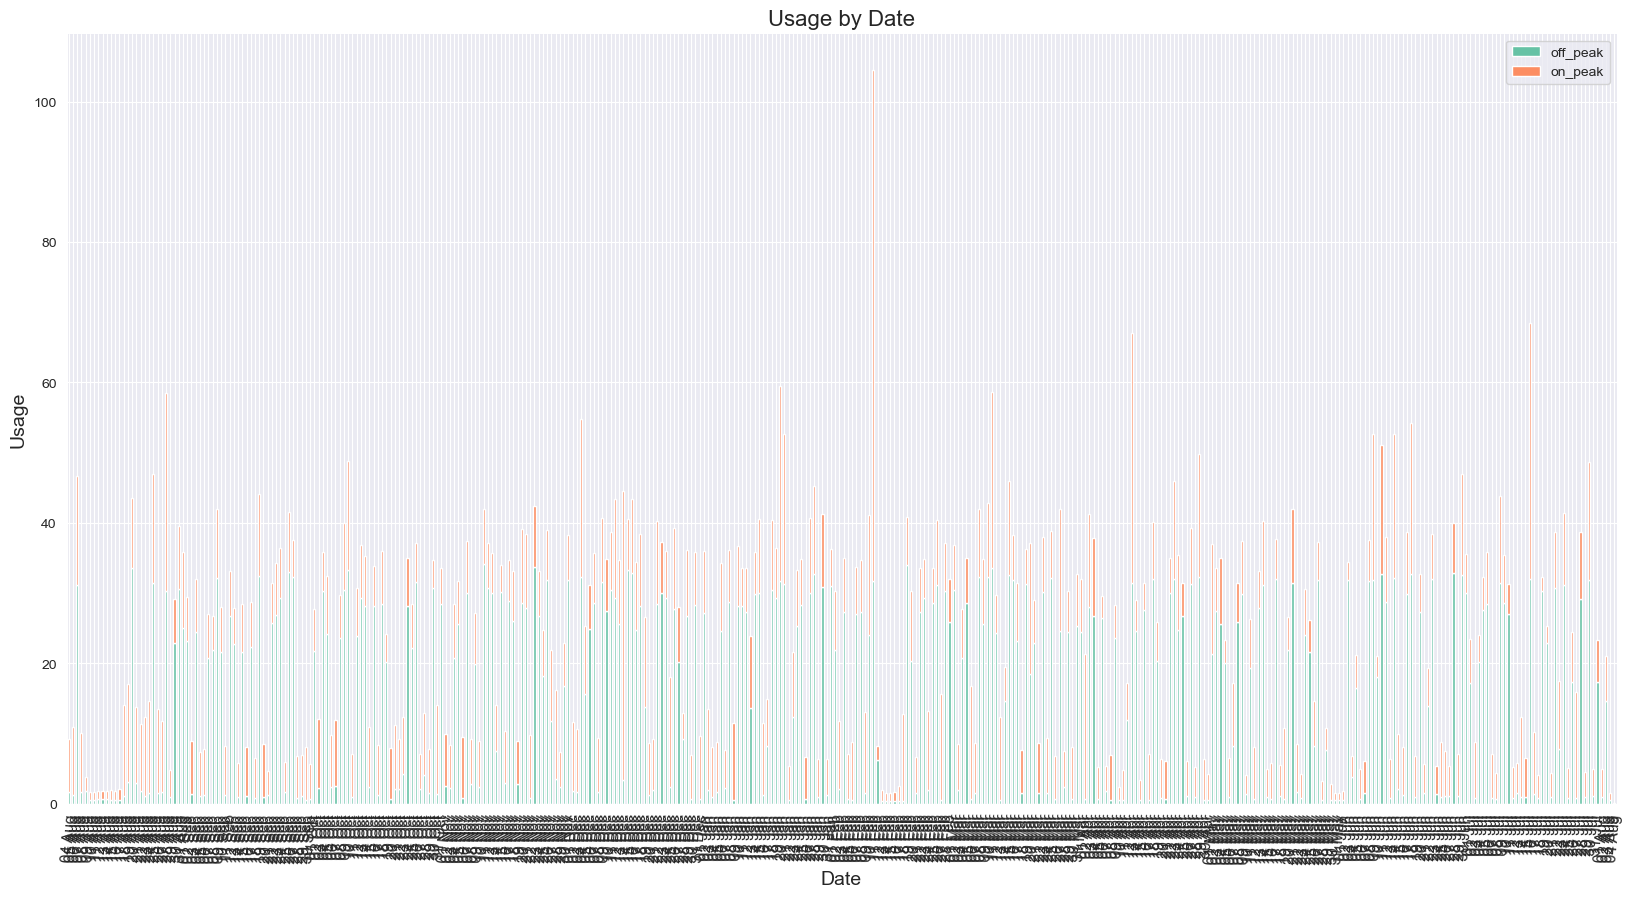

In [70]:

# Draw graphs and show ratios of peak to off peak usage

off_peak = off_peak.resample('D').sum()
on_peak = on_peak.resample('D').sum()
 
off_peak.rename(columns={'usage':'off_peak'}, inplace=True)
on_peak.rename(columns={'usage':'on_peak'}, inplace=True)
 
usage_df = pd.concat([off_peak, on_peak], axis=1)
usage_df['usage'] = usage_df.off_peak + usage_df.on_peak
usage_df['percent_off_peak'] = (usage_df.off_peak * 100 / usage_df.usage).round().astype(int)
 
sns.set_style('darkgrid')
sns.set_palette('Set2')
 
ax = usage_df.plot(kind='bar', stacked=True, y=['off_peak','on_peak'], figsize=(20,10))

ax.set_xticklabels(usage_df.index.strftime("%d %b"))
plt.gca().xaxis.set_major_locator(dates.DayLocator(interval=1))
 
plt.title('Usage by Date', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Usage', fontsize=14)
plt.xticks(rotation=85, fontsize=11)
sns.despine()
plt.plot()

print("Average usage on non-charging days is %s (kWh)" % round(non_charging_days['usage'].mean()))
calculated = round(usage_df.loc['2022-08-09']['off_peak']*24/4,2)
actual = round(usage_df.loc['2022-08-09']['usage'],2)
print("Baseline usage should be %s kWh" % calculated)
print("Actual usage was %s kWh" % actual)
print("Which means that you consumed %s kWh of solar on this day" % round((calculated - actual),2))
